In [1]:
from email import message_from_string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch
import re

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./dataset/Processed_datasets/nazario_2015_dataset.csv")

def extract_mail_components(text):
    try:
        msg = message_from_string(text)
        m_body = msg.get_payload()
        m_from = msg.get('From', '')
        m_return = msg.get('Return-Path', '')

        re_find = r'<([^>]*)>' 

        m_from = re.findall(re_find, m_from)[0] if re.findall(re_find, m_from) else ''
        m_return = re.findall(re_find, m_return)[0] if re.findall(re_find, m_return) else ''

        m_body = str(m_body)
        m_from = str(m_from)
        m_return = str(m_return)

        return m_body, m_from, m_return
    except Exception as e:
        print(f"Error processing text: {text[:100]}... Error: {e}")
        return '', '', ''  # Return empty values if there is an error processing the text

def extract_urls(text):
    import re
    url_list = []
    ipv4_pattern = r'(?:https?|ftp)?://(?:\d{1,3}\.){3}\d{1,3}(?::\d+)?(?:/\S*)?'
    url_pattern = (
        r'(?:(?:https?|ftp):\/\/)?'
        r'(?:[a-zA-Z0-9.%+-]+:[a-zA-Z0-9.%+-]+@)?'
        r'(?:www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
        r'(?:\/\S*)?'
        r'|'
        + ipv4_pattern
    )
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    # Split the input string into words
    words = text.split()

    for word in words:
        if re.fullmatch(email_pattern, word):
            # Check if it also matches a URL and additional conditions
            if re.fullmatch(url_pattern, word):
                if word.count('@') > 1 or ":" in word.split('@')[-1]:
                    url_list.append(word)
        elif re.fullmatch(url_pattern, word):
            url_list.append(word)

    return url_list


df[['Body', 'From', 'Return-Path']] = df['Content'].apply(extract_mail_components).apply(pd.Series)
df['Urls'] = df['Body'].apply(extract_urls)

test_texts = df['Body'].tolist()
test_labels = df['Label'].tolist()

tokenizer = BertTokenizer.from_pretrained("saved_model_bodyOnly")
model = BertForSequenceClassification.from_pretrained("saved_model_bodyOnly")

# Tokenize data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

test_dataset = Dataset(test_encodings, test_labels)

In [4]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != 'labels'}
        outputs = model(**inputs)
        preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Evaluation metrics
print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:\n", classification_report(true_labels, preds))

C:\Users\Asus\AppData\Local\Temp\ipykernel_13924\1587964162.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.3137254901960784
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.31      0.48       306

    accuracy                           0.31       306
   macro avg       0.50      0.16      0.24       306
weighted avg       1.00      0.31      0.48       306



c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Confusion Matrix:
 [[  0   0]
 [210  96]]


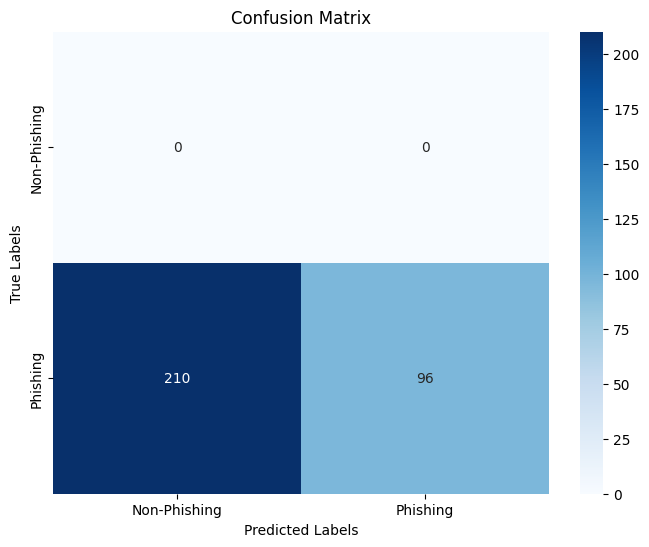

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()